<a href="https://colab.research.google.com/github/SuYirouCrystal/ml_geospatial/blob/main/ldm_atex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Install dependencies
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip -q install diffusers==0.30.0 accelerate==0.34.2 transformers==4.44.2 safetensors einops pillow matplotlib

import os, glob, random, math, json, time
from pathlib import Path
import numpy as np
from PIL import Image

import torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils as tvutils

from diffusers import AutoencoderKL, UNet2DModel, DDPMScheduler
from accelerate import Accelerator

from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [20]:
# Clone ATEX dataset
repo_url = "https://github.com/smhassanerfani/atex.git"
root = Path("/content")
ds_root = root / "atex"

if not ds_root.exists():
    !git clone {repo_url} {ds_root}

data_dir = ds_root / "data" / "atex"
assert data_dir.exists(), "ATeX dataset not found under data/atex."

def list_images(p: Path):
    exts = ["*.png","*.jpg","*.jpeg","*.bmp","*.webp"]
    files = []
    for e in exts: files += glob.glob(str(p / "**" / e), recursive=True)
    return sorted(files)

all_imgs = list_images(data_dir)
assert len(all_imgs) > 0, "No images found."

# Split
random.shuffle(all_imgs)
n_val = int(0.1 * len(all_imgs))
val_imgs, train_imgs = all_imgs[:n_val], all_imgs[n_val:]
print(f"Train={len(train_imgs)} | Val={len(val_imgs)}")

Train=11253 | Val=1250


In [21]:
# Transforms and Dataset Loader

IMG_SIZE = 32
AUG = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

VAL_TF = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class ImgDS(Dataset):
    def __init__(self, paths, tfm): self.paths, self.tfm = paths, tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.tfm(img)

train_ds = ImgDS(train_imgs, AUG)
val_ds   = ImgDS(val_imgs, VAL_TF)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

In [22]:
# Latent Diffusion Model (LDM) setup
VAE_ID = "stabilityai/sd-vae-ft-ema"
vae = AutoencoderKL.from_pretrained(VAE_ID)
for p in vae.parameters():
    p.requires_grad_(False)
vae.eval()

LATENT_CH = 4
LAT_H = IMG_SIZE // 8

unet = UNet2DModel(
    sample_size=LAT_H,
    in_channels=LATENT_CH,
    out_channels=LATENT_CH,
    layers_per_block=2,
    block_out_channels=(192,384,384),
    down_block_types=("DownBlock2D","DownBlock2D","DownBlock2D"),
    up_block_types=("UpBlock2D","UpBlock2D","UpBlock2D"),
)

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
    prediction_type="epsilon"
)

In [23]:
# Training Preparation

from copy import deepcopy
accelerator = Accelerator(mixed_precision="fp16")
device = accelerator.device
vae = vae.to(device)
unet = unet.to(device)

opt = torch.optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-4)

class EMA:
    def __init__(self, model, mu=0.999):
        self.mu = mu
        self.shadow = deepcopy(model.state_dict())
    @torch.no_grad()
    def update(self, model):
        for k,v in model.state_dict().items():
            self.shadow[k].lerp_(v.detach(), 1 - self.mu)
    @torch.no_grad()
    def copy_to(self, model):
        model.load_state_dict(self.shadow, strict=True)

ema = EMA(unet)
train_loader, unet, opt = accelerator.prepare(train_loader, unet, opt)

In [24]:
# encode/decode helper
@torch.no_grad()
def encode_latents(x):
    posterior = vae.encode(x).latent_dist
    return posterior.sample() * vae.config.scaling_factor

@torch.no_grad()
def decode_latents(z):
    z = z / vae.config.scaling_factor
    return (vae.decode(z).sample + 1) / 2

In [27]:
# train & validation loops

def train_one_epoch(loader, epoch_idx=1, total_epochs=1, log_every=50):
    unet.train()
    losses = []
    running = 0.0
    progress = tqdm(total=len(loader), desc=f"Epoch {epoch_idx}/{total_epochs} [train]", leave=False)
    step = 0

    for x in loader:
        step += 1
        x = x.to(device, non_blocking=True)
        with torch.no_grad():
            z = encode_latents(x)  # LDM: learn in latent space

        noise = torch.randn_like(z)
        t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (z.size(0),), device=device)
        noisy_z = noise_scheduler.add_noise(z, noise, t)
        pred = unet(noisy_z, t).sample
        loss = F.mse_loss(pred, noise)

        accelerator.backward(loss)
        opt.step(); opt.zero_grad(set_to_none=True)
        ema.update(unet)

        val = loss.detach().float().mean().item()
        running += val
        losses.append(val)

        # live progress
        if step % log_every == 0 and accelerator.is_main_process:
            avg = running / log_every
            tqdm.write(f"[train] epoch={epoch_idx} step={step}/{len(loader)} loss={avg:.4f}")
            running = 0.0

        progress.update(1)

    progress.close()
    return float(np.mean(losses)) if losses else 0.0


@torch.no_grad()
def val_one_epoch(loader, epoch_idx=1, total_epochs=1):
    unet.eval()
    losses = []
    progress = tqdm(total=len(loader), desc=f"Epoch {epoch_idx}/{total_epochs} [valid]", leave=False)
    for x in loader:
        x = x.to(device, non_blocking=True)
        z = encode_latents(x)
        noise = torch.randn_like(z)
        t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (z.size(0),), device=device)
        noisy_z = noise_scheduler.add_noise(z, noise, t)
        pred = unet(noisy_z, t).sample
        losses.append(F.mse_loss(pred, noise).float().mean().item())
        progress.update(1)
    progress.close()
    return float(np.mean(losses)) if losses else 0.0

# Sample
@torch.no_grad()
def sample_ldm(n=25, steps=50, use_ema=True, seed=7, save_path=None):
    if use_ema:
        ema.copy_to(unet)
    scheduler = DDPMScheduler(
        num_train_timesteps=noise_scheduler.config.num_train_timesteps,
        beta_schedule="squaredcos_cap_v2",
        prediction_type="epsilon",
        clip_sample=False
    )
    scheduler.set_timesteps(steps)

    g = torch.Generator(device=device).manual_seed(seed)
    latents = torch.randn(n, LATENT_CH, LAT_H, LAT_H, generator=g, device=device)

    for t in scheduler.timesteps:
        pred = unet(latents, t).sample
        latents = scheduler.step(pred, t, latents).prev_sample

    imgs = decode_latents(latents).clamp(0,1)
    grid = tvutils.make_grid(imgs, nrow=int(math.sqrt(n)))
    out = save_path or (SAVE_DIR / f"atex_ldm_samples_{n}.png")
    tvutils.save_image(grid, out)
    return out

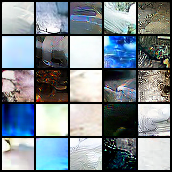

In [29]:
# training loop

SAVE_DIR = Path("/content/ldm_atex")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

best_val = float("inf")
EPOCHS = 5               # can change with more time
LOG_EVERY = 50
PREVIEW_EVERY = 5

for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr = train_one_epoch(train_loader, epoch_idx=ep, total_epochs=EPOCHS, log_every=LOG_EVERY)
    va = val_one_epoch(val_loader, epoch_idx=ep, total_epochs=EPOCHS)
    dt = time.time() - t0

    if accelerator.is_main_process:
        print(f"[{ep:03d}/{EPOCHS}] train={tr:.4f}  val={va:.4f}  ({dt:.1f}s)", flush=True)

        # Save rolling checkpoint (EMA snapshot)
        tmp = {k: v.detach().cpu() for k,v in unet.state_dict().items()}
        ema.copy_to(unet)
        torch.save(unet.state_dict(), SAVE_DIR / f"unet_ema_epoch{ep:03d}.safetensors")
        unet.load_state_dict(tmp, strict=True)

        if va < best_val:
            best_val = va
            torch.save(tmp, SAVE_DIR / "unet_best_train.safetensors")
            ema.copy_to(unet)
            torch.save(unet.state_dict(), SAVE_DIR / "unet_best_ema.safetensors")
            unet.load_state_dict(tmp, strict=True)
            print(f"✅ new best val={va:.4f} @ epoch {ep}", flush=True)

        # Live preview every few epochs
        if ep % PREVIEW_EVERY == 0:
            _ = sample_ldm(n=25, steps=50, use_ema=True, seed=ep)  # saves PNG
            try:
                clear_output(wait=True)
                from PIL import Image as PILImage
                img_path = SAVE_DIR / f"atex_ldm_samples_25.png"
                display(PILImage.open(img_path))
            except Exception as e:
                print("Preview display failed:", e, flush=True)

In [31]:
# export final model

out_dir = SAVE_DIR / "ldm_export"
out_dir.mkdir(parents=True, exist_ok=True)
ema.copy_to(unet)
torch.save(unet.state_dict(), out_dir / "unet_ema.safetensors")

(out_dir / "config.json").write_text(json.dumps({
    "vae_id": "stabilityai/sd-vae-ft-ema",
    "latent_shape": [LATENT_CH, LAT_H, LAT_H],
    "scheduler": "DDPM-squaredcos_cap_v2",
    "note": "This is a Latent Diffusion Model (UNet trained on VAE latents)."
}, indent=2))
print("✅ Exported LDM model to", out_dir)

✅ Exported LDM model to /content/ldm_atex/ldm_export
